## **Final Project - House Price Prediction** ##

Import required libraries:

In [1]:
import urllib.request
import bs4
from datetime import datetime
import re
import pandas as pd
from dateutil import parser
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from matplotlib.ticker import Formatter
import seaborn as sns

### Parse the housing data webpage HTML to retrieve the data, and format in a pandas DataFrame including all relevant descriptive features: ###

In [2]:
# Attempt to fetch URL
url = "http://mlg.ucd.ie/modules/python/housing/"
try:
    response = urllib.request.urlopen(url)
    html = response.read().decode()
except:
    print("Failed to retrieve %s" % url)

# Parse HTML
soup_parser = bs4.BeautifulSoup(html,"html.parser") 

count_house=0 # track number of houses 
data = [] # stores formatted row for each house
for row in soup_parser.find('table').tbody.find_all('tr'):
    # Extracting all cells in  row
    cells = row.find_all('td')
    
    # Data extraction per column, commas removed for convenience
    sale_date = cells[0].text.strip().replace(',', '')
    location = cells[1].text.strip()
    price = cells[2].text.strip().replace(',', '')
    year_built = cells[3].text.strip()
    size = cells[4].text.strip().replace(',', '')
    description = cells[5].text.strip()
    
    # Regular expression to extract additional details from description
    bedrooms_match = re.search(r'(\d+)\s*Bedroom', description)
    bathrooms_match = re.search(r'(\d+)\s*Bathroom', description)
    type_match = re.search(r'Type:\s*([^;]+)', description)
    style_match = re.search(r'Style:\s*([^;]+)', description)

    num_bedrooms = bedrooms_match.group(1) if bedrooms_match else None
    num_bathrooms = bathrooms_match.group(1) if bathrooms_match else None
    house_type = type_match.group(1).strip() if type_match else None
    house_style = style_match.group(1).strip() if style_match else None

    # Append a dictionary of the row data to the data list
    data.append({
        'Date of Sale': sale_date,
        'Location': location,
        'Price': price,
        'Year Built': year_built,
        'Size': size,
        'Bedrooms': num_bedrooms,
        'Bathrooms': num_bathrooms,
        'House Type': house_type,
        'House Style': house_style
    })

    count_house += 1
    
# Store data in a DataFrame
df = pd.DataFrame(data)
df.head()

,Date of Sale,Location,Price,Year Built,Size,Bedrooms,Bathrooms,House Type,House Style
0,06 Jan 2020,West End,€732986.00,2010,1696 sq ft,3,2,Detached,2-Storey
1,06 Jan 2020,West End,€985889.00,2004,2355 sq ft,4,2,Detached,2-Storey
2,07 Jan 20,Brookville,€1047124.00,2013,1836 sq ft,3,2,Detached,2-Storey
3,07 Jan 2020,Brookville,€516439.00,2000,1000 sq ft,3,1,Detached,1-Storey
4,16 Jan 2020,Brookville,€890423.00,2011,1536 sq ft,3,2,Detached,1-Storey


### Initial Data Exploration is carried out to understand the dataset more thoroughly: ###

In [3]:
# Print sample of 'Date of Sale' entries
print(df['Date of Sale'].head())

missing_count = df['Date of Sale'].isnull().sum()
print(f"Missing values in 'Date of Sale': {missing_count}")

0    06 Jan 2020
1    06 Jan 2020
2      07 Jan 20
3    07 Jan 2020
4    16 Jan 2020
Name: Date of Sale, dtype: object
Missing values in 'Date of Sale': 0


At least 2 date formats used here, must be standardised

In [4]:
cols = ['Location', 'Bedrooms', 'Bathrooms', 'House Type', 'House Style']
print("Column Summaries:")
for column in cols:
    missing_count = df[column].isnull().sum()
    
    # Retrieve unique values using unique()
    unique_values = np.sort(df[column].dropna().unique())

    # Output the results
    print(df[column].value_counts())
    print(f"Unique Entries: {unique_values}")
    print(f"Missing Entries: {missing_count}\n")
    

Column Summaries:
Location
Clarawood      245
Brookville     183
Rivermount     142
Mile End       132
West End       119
Redbridge       98
Maple Ridge     90
Name: count, dtype: int64
Unique Entries: ['Brookville' 'Clarawood' 'Maple Ridge' 'Mile End' 'Redbridge'
 'Rivermount' 'West End']
Missing Entries: 0

Bedrooms
3    597
2    223
4    147
1     28
5     14
Name: count, dtype: int64
Unique Entries: ['1' '2' '3' '4' '5']
Missing Entries: 0

Bathrooms
2    551
1    421
3     37
Name: count, dtype: int64
Unique Entries: ['1' '2' '3']
Missing Entries: 0

House Type
Detached          830
Semi-Detached      56
Terraced           31
End-of-Terrace     30
Duplex             29
Semi-D              6
Bunaglow            5
EndOfTerrace        4
Name: count, dtype: int64
Unique Entries: ['Bunaglow' 'Detached' 'Duplex' 'End-of-Terrace' 'EndOfTerrace' 'Semi-D'
 'Semi-Detached' 'Terraced']
Missing Entries: 18

House Style
1-Storey      525
2-Storey      341
Dormer         66
One-Storey     50
Tw

Location, Bedrooms & Bathrooms variables are all without issues, no missing values and valid unique entries. House Type & House Style both contain missing values, and there are multiple formats being used, i.e. '1-Storey' and 'One-Storey'. These must be standardised also

In [5]:
# function reads values and checks for a particular RegEx format
def check_values(values, format_regex):
    invalid_entries = []
    count = 0
    for value in values:
        if not re.match(format_regex, str(value)):
            count += 1
            invalid_entries.append(value)
    return invalid_entries, count

# Define columns and their corresponding RegEx formats
columns = ['Price', 'Year Built']
regex_formats = {
    'Price': r'^€\d{1,9}.00$',
    'Year Built': r'^(1[7-9]\d{2}|20[0-1]\d|202[0-3])$'
}

# Iterate through columns and check values
for column in columns:
    invalid_entries, count = check_values(df[column], regex_formats[column])
    
    # Print the results
    print(f"Total number of '{column}' entries: {len(df[column])}")
    missing_count = df[column].isnull().sum()
    print(f"Missing values in '{column}': {missing_count}")
    print(f"Number of invalid entries for '{column}': {count}")
    # display invalid entries if present
    if count>0:
        print(f"List of invalid entries for '{column}': {list(set(invalid_entries))}")
    print()

Total number of 'Price' entries: 1009
Missing values in 'Price': 0
Number of invalid entries for 'Price': 0

Total number of 'Year Built' entries: 1009
Missing values in 'Year Built': 0
Number of invalid entries for 'Year Built': 20
List of invalid entries for 'Year Built': ['????']



Price values are all in '€XXXX.00' format, so these can be easily converted to integers. 'Year Built' contains 20 invalid entries, all of which are '????'. These must be replaced, but all other entries are valid

In [6]:
# iterate through each size entry to ensure only 3 or 4 digit values present
for size_entry in df['Size']:
    # Find all integer numbers in the string
    numbers = re.findall(r'\d+', size_entry)
    
    # Check if exactly one number is found and it is within the specified range
    if len(numbers) == 1:
        number = int(numbers[0])  # Convert the found number to integer
        if number <= 100 or number >= 10000:
            print(f"Error in entry '{size_entry}': Number out of allowed range (100, 10000)")
    else:
        print(f"Error in entry '{size_entry}': More than one number found or no numbers found.")

No errors found in the Size column either, with all values being either 3 or 4 digit numbers which can be converted to integers.

### Data must undergo preprocessing and reformatting to ensure uniformity: ###

In [7]:
# Initialize new data frame

houses = df.copy()


# DATE OF SALE

# convert all date entries to '%d-%b-%Y' date format
def format_date(date_str):
    # Try parsing the date with a flexible parser
    try:
        # Parse date
        parsed_date = parser.parse(date_str)
        
        # Convert the parsed date to standard format
        formatted_date = parsed_date.strftime("%d-%b-%Y")
        
        # Check if re-parsing it matches the original parsed date
        test_parse = datetime.strptime(formatted_date, "%d-%b-%Y")
        
        # Check if the re-parsed date matches the parsed date
        if test_parse == parsed_date:
            return formatted_date
        else:
            return None
    except ValueError:
        print(f"Failed to parse: {date_str}")
        return None

# Standardise dates
houses['Date of Sale'] = houses['Date of Sale'].apply(format_date)

# Set column to datetime
houses['Date of Sale'] = pd.to_datetime(houses['Date of Sale'], format="%d-%b-%Y")


# HOUSE TYPE & HOUSE STYLE 

# Fixing irregular cardinality 
houses.loc[houses['House Type'] == 'Semi-D','House Type'] = "Semi-Detached"
houses.loc[houses['House Type'] == 'EndOfTerrace','House Type'] = "End-of-Terrace"
houses.loc[houses['House Style'] == 'One-Storey','House Style'] = "1-Storey"
houses.loc[houses['House Style'] == 'Two-Storey','House Style'] = "2-Storey"

# Correcting misspelling of bungalow
houses['House Type'] = houses['House Type'].replace('Bunaglow', 'Bungalow')

# Ensure all entries with 'House Type' = 'Bungalow' have 'House Style' = '1-Storey'
bungalow_errors = (houses['House Type'] == 'Bungalow') & (houses['House Style'] != '1-Storey')
houses.loc[bungalow_errors, 'House Style'] = '1-Storey'



# BATHROOMS, BEDROOMS, PRICE & SIZE 

# Ensuring 'Bathrooms' and 'Bedrooms' columns are type int
houses['Bathrooms'] = houses['Bathrooms'].astype(int)
houses['Bedrooms'] = houses['Bedrooms'].astype(int)

# Remove Price formatting berfore comverting 'Price' column to int
houses['Price'] = houses['Price'].str.replace('€', '').str.replace('.00', '').astype(int)

# function that converts 'Size' entry to integer
def process_size_entry(size_str):
    # Find all integer numbers in the string
    numbers = re.findall(r'\d+', size_str)
    # Return the first number found as an integer, or None if no number is found
    return int(numbers[0]) if len(numbers)==1 else None

# implement 'process_size_entry' function for all house size entries
houses['Size'] = houses['Size'].apply(process_size_entry)


# YEAR BUILT

# Convert years to integers, or NaN for invalid entries
houses['Year Built'] = pd.to_numeric(houses['Year Built'], errors='coerce')

# Gather median and SD values for each locations's 'Year Built' stats
stats = houses.groupby('Location')['Year Built'].agg(['median', 'std'])

# Replace missing values with median of location of SD is less than 11 years
def replace_missing(row):
    if pd.isna(row['Year Built']):
        location_stats = stats.loc[row['Location']]
        if location_stats['std'] < 11:
            return location_stats['median']
    return row['Year Built']

# Apply the function across the DataFrame
houses['Year Built'] = houses.apply(replace_missing, axis=1)

houses = houses.dropna()
print(len(houses))
houses.head()


976


,Date of Sale,Location,Price,Year Built,Size,Bedrooms,Bathrooms,House Type,House Style
0,2020-01-06,West End,732986,2010.0,1696,3,2,Detached,2-Storey
1,2020-01-06,West End,985889,2004.0,2355,4,2,Detached,2-Storey
2,2020-01-07,Brookville,1047124,2013.0,1836,3,2,Detached,2-Storey
3,2020-01-07,Brookville,516439,2000.0,1000,3,1,Detached,1-Storey
4,2020-01-16,Brookville,890423,2011.0,1536,3,2,Detached,1-Storey


## Data Exploration can now be taken further, as we examine the relationships between variables in the DataFrame and distributions of each variable

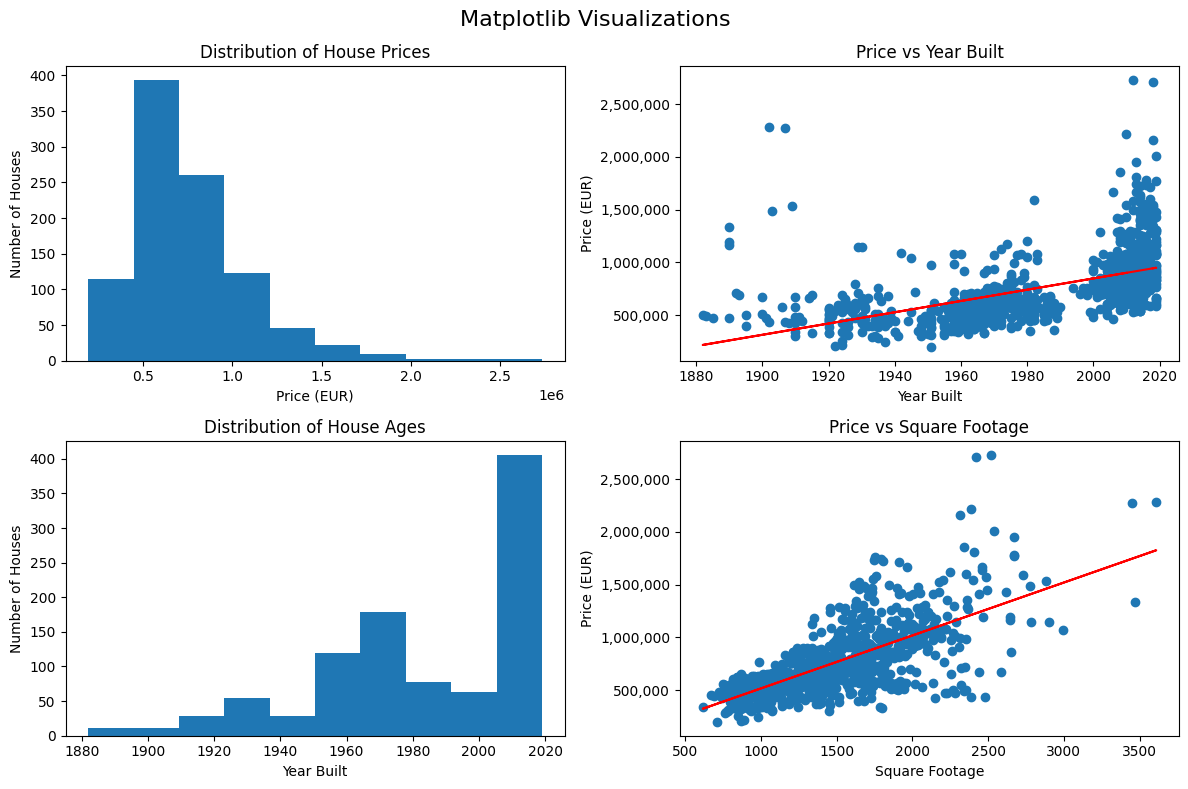

In [32]:
price = houses['Price']
bedrooms = houses['Bedrooms']
bathrooms = houses['Bathrooms']
house_type = houses['House Type']
year_built = houses['Year Built']
size = houses['Size']

# Function to format price axis labels with commas
def price_formatter(x, pos):
    return f"{x:,.0f}"  # Format as comma separated thousands with no decimals

# Create a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Univariate Analysis - Price distribution
axes[0, 0].hist(price)
axes[0, 0].set_xlabel("Price (EUR)")
axes[0, 0].set_ylabel("Number of Houses")
axes[0, 0].set_title("Distribution of House Prices")

#Price vs Year Built
m, b = np.polyfit(year_built, price, 1)  # Slope (m) and intercept (b)
axes[0, 1].scatter(year_built, price) 
axes[0, 1].plot(year_built, m*year_built + b, color='red')
axes[0, 1].set_xlabel("Year Built")
axes[0, 1].set_ylabel("Price (EUR)")
axes[0, 1].set_title("Price vs Year Built")

# Univariate Analysis - Price distribution
axes[1, 0].hist(year_built)
axes[1, 0].set_xlabel("Year Built")
axes[1, 0].set_ylabel("Number of Houses")
axes[1, 0].set_title("Distribution of House Ages")

# Price vs Size
axes[1, 1].scatter(size, price) 
m, b = np.polyfit(size, price, 1)  # Slope (m) and intercept (b)
axes[1, 1].plot(size, m*size + b, color='red')
axes[1, 1].set_xlabel("Square Footage")
axes[1, 1].set_ylabel("Price (EUR)")
axes[1, 1].set_title("Price vs Square Footage")

# Apply the formatter to price related y-axes
for ax in axes.flat:
    if ax.get_ylabel() == "Price (EUR)":
        ax.yaxis.set_major_formatter(price_formatter)

# Adjust layout
fig.suptitle("Matplotlib Visualizations", fontsize=16)
plt.tight_layout()
plt.show()

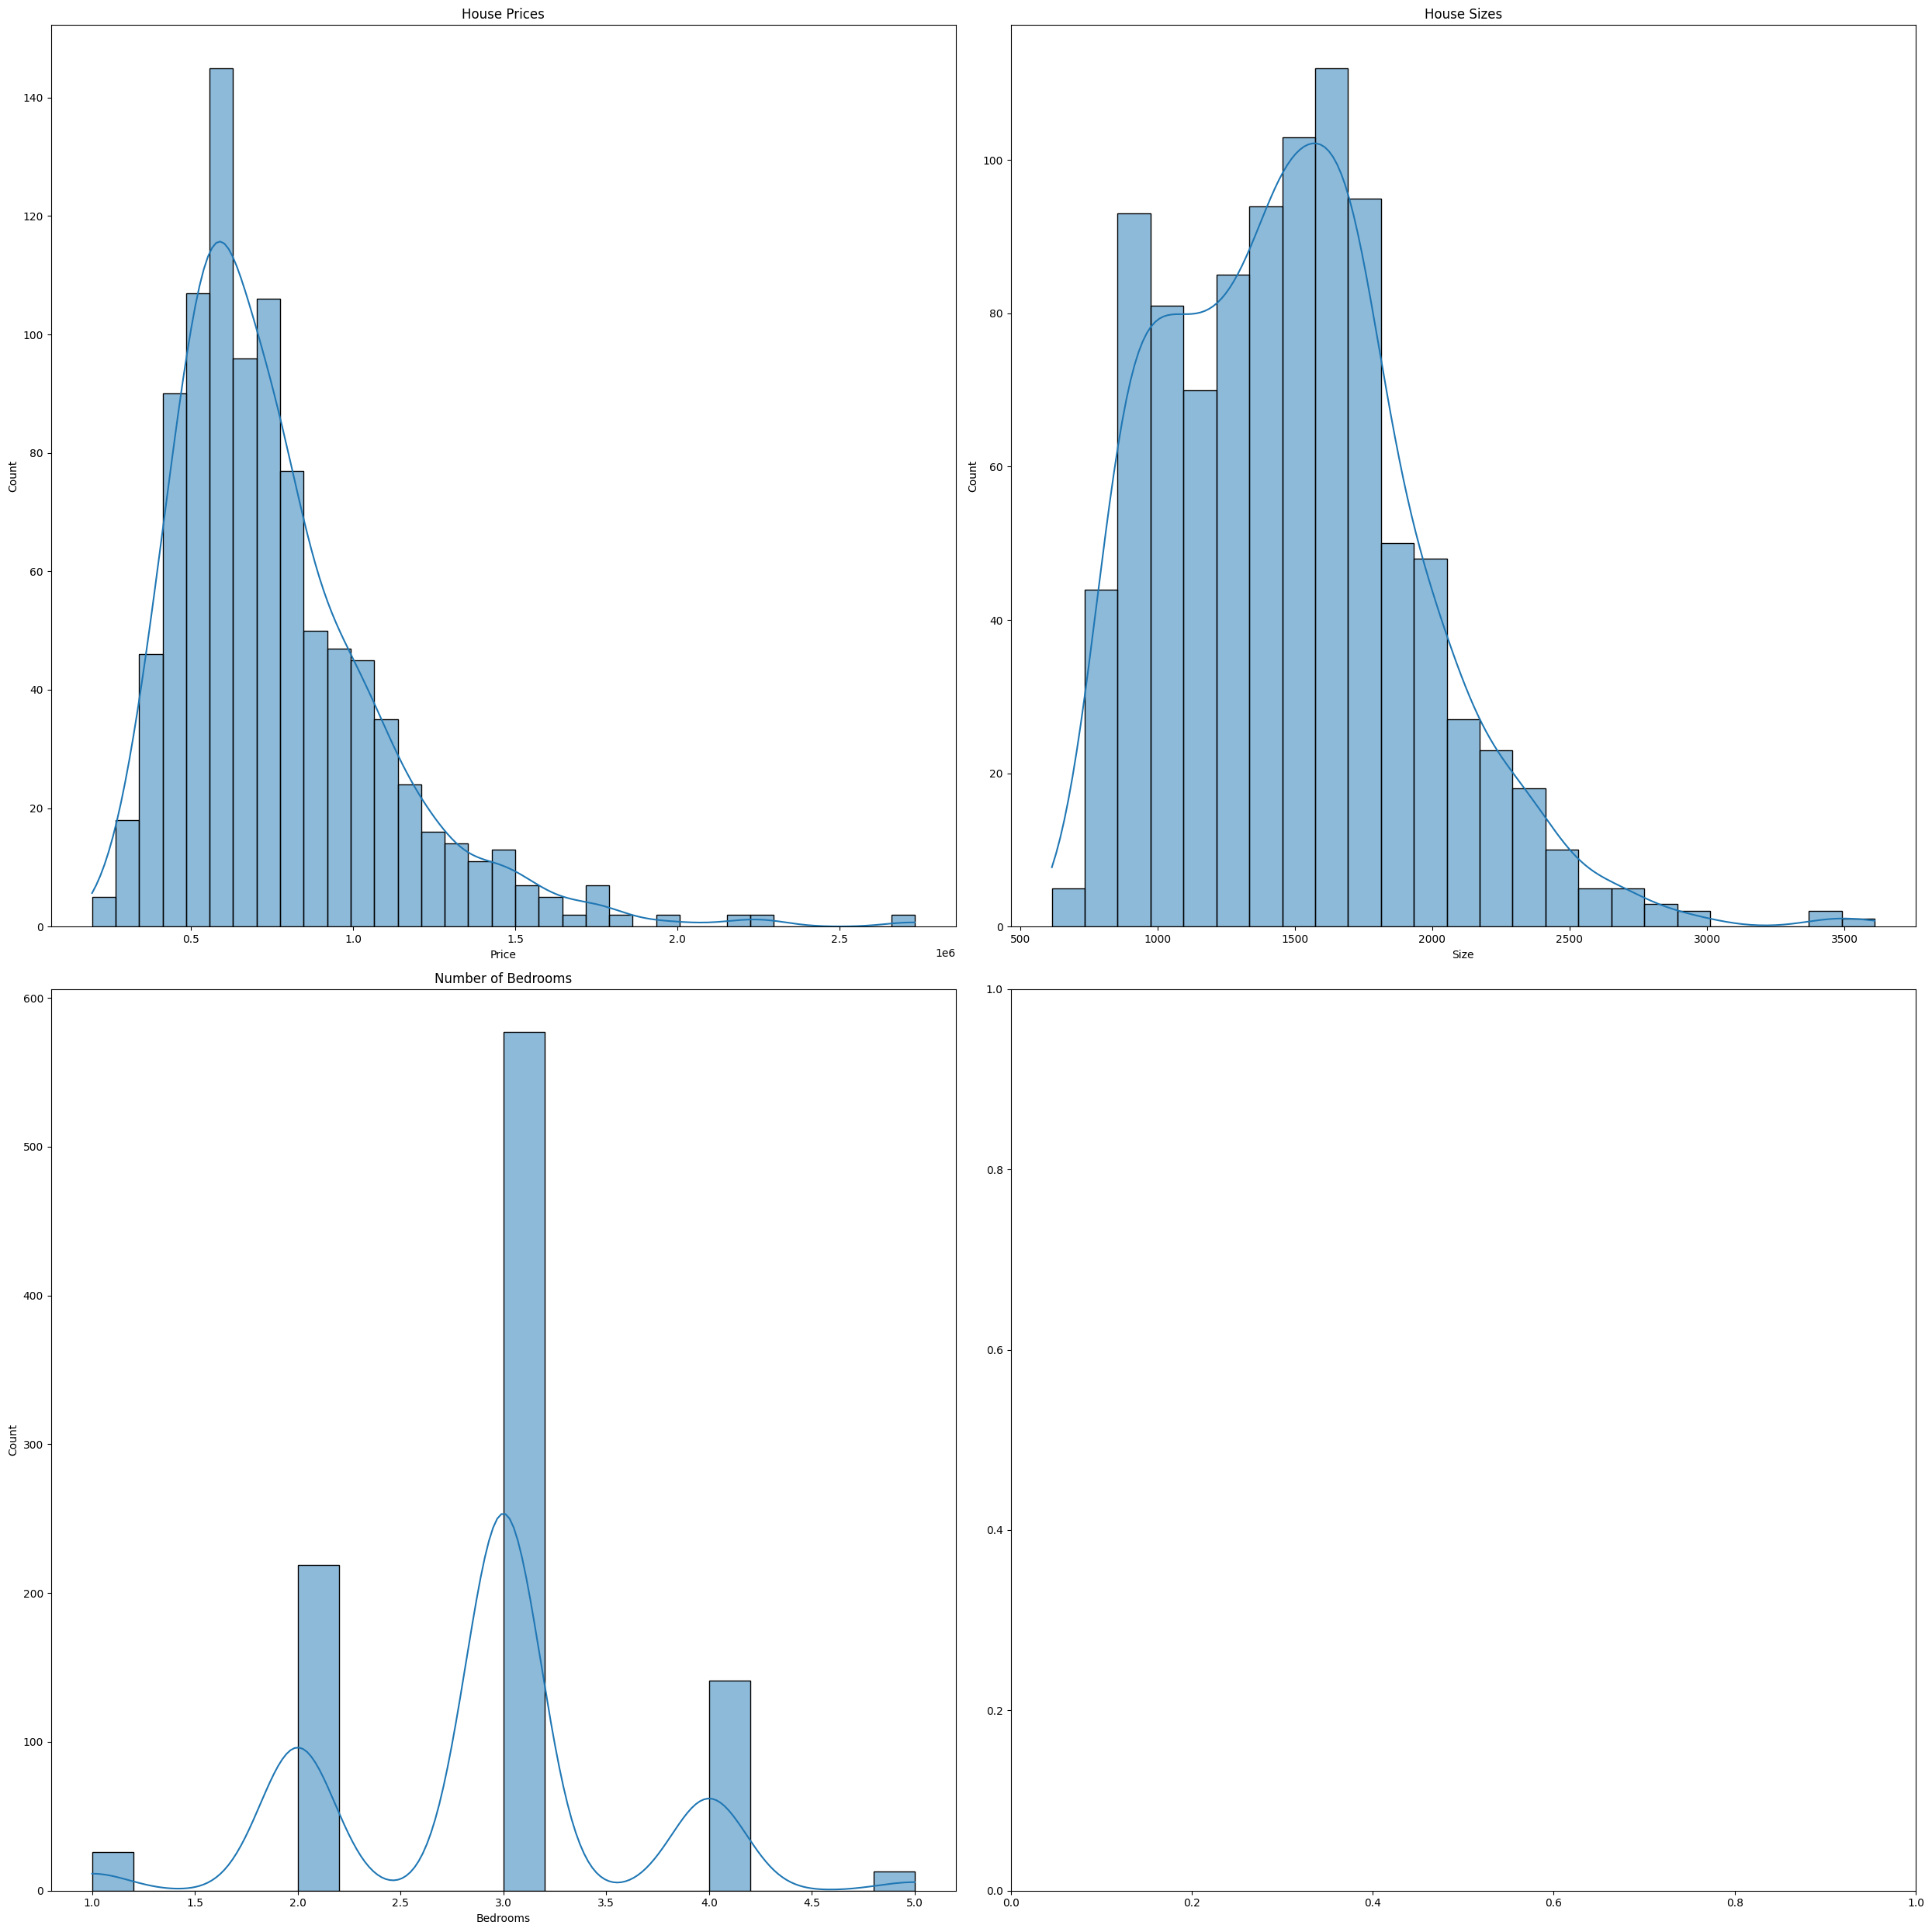

In [25]:
cols = ["Date of Sale", "Location", "Price", "Year Built", "Size", "Bedrooms", "Bathrooms", "House Type", "House Style"]

fig, axs = plt.subplots(2, 2, figsize=(25, 25))

#Plot house prices using seaborn
sns.histplot(data=houses, x='Price', kde=True, ax=axs[0,0])
axs[0,0].set_title('House Prices')

#Plot house Sizes using seaborn
sns.histplot(data=houses, x='Size', kde=True, ax=axs[0,1])
axs[0,1].set_title('House Sizes')

#Plot house Bedrooms using seaborn
sns.histplot(data=houses, x='Bedrooms', kde=True, ax=axs[1,0])
axs[1,0].set_title('Number of Bedrooms')


plt.tight_layout()
plt.show()